In [1]:
!pip install transformers
!pip install datasets

import time
import os
from argparse import Namespace
import random
from sklearn.metrics import accuracy_score
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

import pandas as pd
from tqdm import tqdm

from tensorflow.keras.preprocessing.sequence import pad_sequences

from transformers import BertTokenizerFast
from transformers import BertForSequenceClassification
from transformers import Trainer
from transformers import TrainingArguments
from transformers import AdamW, get_linear_schedule_with_warmup

from sklearn.model_selection import train_test_split

# for graphing
import seaborn as sns
import matplotlib.pyplot as plt

# Setup logging
import logging

logger = logging.getLogger(__name__)
logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.WARN)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 60.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 19.6 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [2]:
from datasets import load_dataset

dataset = load_dataset("klue", "nli")

dataset

Generating train split:   0%|          | 0/24998 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3000 [00:00<?, ? examples/s]

Dataset klue downloaded and prepared to /root/.cache/huggingface/datasets/klue/nli/1.0.0/e0fc3bc3de3eb03be2c92d72fd04a60ecc71903f821619cb28ca0e1e29e4233e. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['guid', 'source', 'premise', 'hypothesis', 'label'],
        num_rows: 24998
    })
    validation: Dataset({
        features: ['guid', 'source', 'premise', 'hypothesis', 'label'],
        num_rows: 3000
    })
})

In [17]:
# argment setting
model_checkpoint = "bert-base-multilingual-cased"
batch_size_per_device = 32
max_length = 128
n_epochs = 3
warmup_ratio = .2
lr = 5e-5

In [4]:
# load model&tokenizerx
tokenizer = BertTokenizerFast.from_pretrained(model_checkpoint, use_fast=True)

In [5]:
def preprocess_function(examples):
    return tokenizer(examples['premise'], examples['hypothesis'],
                     truncation=True, max_length=max_length, padding=True)

In [6]:
encoded_dataset = dataset.map(preprocess_function, batched=True)

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

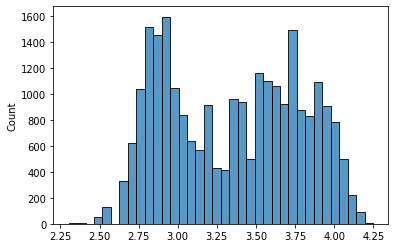

log value : 4.624955057798193
original value : 101.99818895649804


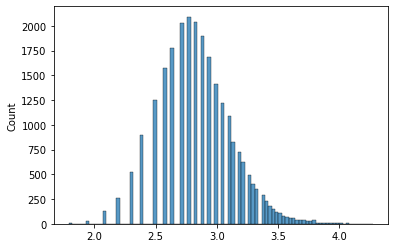

log value : 3.799594569269241
original value : 44.683064932767444


In [7]:
# 훈련셋의 앞부분 출력
tokenizer_len = [len(tokenizer(s)['input_ids']) for s in encoded_dataset['train']['premise']]
tokenizer_log = np.log(tokenizer_len)
sns.histplot(tokenizer_log)
plt.show()

print(f'log value : {np.mean(tokenizer_log)+3*np.std(tokenizer_log)}')
print(f'original value : {np.exp(np.mean(tokenizer_log)+3*np.std(tokenizer_log))}')

tokenizer_len = [len(tokenizer(s)['input_ids']) for s in encoded_dataset['train']['hypothesis']]
tokenizer_log = np.log(tokenizer_len)
sns.histplot(tokenizer_log)
plt.show()

print(f'log value : {np.mean(tokenizer_log)+3*np.std(tokenizer_log)}')
print(f'original value : {np.exp(np.mean(tokenizer_log)+3*np.std(tokenizer_log))}')

In [8]:
len_dataset = len(encoded_dataset['train'])
len_validset = len(encoded_dataset['validation'])

print('#train =', len_dataset,
      '#valid =', len_validset
      )

total_batch_size = batch_size_per_device * torch.cuda.device_count()
n_total_iterations = int(len_dataset / total_batch_size * n_epochs)
n_warmup_steps = int(n_total_iterations * warmup_ratio)

print(
        '#total_iters =', n_total_iterations,
        '#warmup_iters =', n_warmup_steps,
      )

#train = 24998 #valid = 3000
#total_iters = 2343 #warmup_iters = 468


In [9]:
# 디바이스 설정
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [10]:
# 분류를 위한 BERT 모델 생성
model = BertForSequenceClassification.from_pretrained(model_checkpoint, num_labels=3)
model.to(device)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [11]:
import os

model_name = model_checkpoint.split("/")[-1]
output_dir = os.path.join("nli")
logging_dir = os.path.join(output_dir, 'logs')
args = TrainingArguments(
    # checkpoint
    output_dir=output_dir,

    # Model Save & Load
    save_strategy = "epoch", # 'steps'
    load_best_model_at_end=True,

    # Dataset
    num_train_epochs=n_epochs,
    per_device_train_batch_size= batch_size_per_device,
    per_device_eval_batch_size= batch_size_per_device,
    
    # Optimizer
    learning_rate=lr, # 5e-5
    weight_decay=0.01,  # 0
    warmup_steps=n_warmup_steps,

    # Resularization
    # max_grad_norm = 1.0,
    # label_smoothing_factor=0.1,

    # Use mixed precision
    # mixed precision mode
    fp16=False,                                 
    #fp16_opt_level="02",  

    # Evaluation 
    metric_for_best_model='eval_accuracy',
    evaluation_strategy = "epoch",

    # Logging
    logging_dir=logging_dir,

    # Randomness
    seed=42,
)

In [12]:
# datasets 라이브러리에서 제공하는 Evaluation metric의 리스트를 확인합니다.
from datasets import list_metrics, load_metric
metrics_list = list_metrics()
len(metrics_list)
print(', '.join(metric for metric in metrics_list))

<ipython-input-12-e741eeb3c60a>:3: FutureWarning: list_metrics is deprecated and will be removed in the next major version of datasets. Use 'evaluate.list_evaluation_modules' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metrics_list = list_metrics()


accuracy, bertscore, bleu, bleurt, brier_score, cer, character, charcut_mt, chrf, code_eval, comet, competition_math, coval, cuad, exact_match, f1, frugalscore, glue, google_bleu, indic_glue, mae, mahalanobis, mape, mase, matthews_correlation, mauve, mean_iou, meteor, mse, nist_mt, pearsonr, perplexity, poseval, precision, recall, rl_reliability, roc_auc, rouge, sacrebleu, sari, seqeval, smape, spearmanr, squad, squad_v2, super_glue, ter, trec_eval, wer, wiki_split, xnli, xtreme_s, BucketHeadP65/confusion_matrix, BucketHeadP65/roc_curve, Drunper/metrica_tesi, Felipehonorato/my_metric, GMFTBY/dailydialog_evaluate, GMFTBY/dailydialogevaluate, JP-SystemsX/nDCG, Josh98/nl2bash_m, KevinSpaghetti/accuracyk, NCSOFT/harim_plus, NikitaMartynov/spell-check-metric, NimaBoscarino/weat, Ochiroo/rouge_mn, Vertaix/vendiscore, Viona/infolm, Vlasta/pr_auc, abdusah/aradiawer, abidlabs/mean_iou, abidlabs/mean_iou2, angelina-wang/directional_bias_amplification, anz2/iliauniiccocrevaluation, bstrai/classif

In [13]:
# YNAT의 metric은 F1 score를 사용합니다.
metric_accuracy = load_metric('accuracy')

<ipython-input-13-49e649c51da0>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric_accuracy = load_metric('accuracy')


In [14]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric_accuracy.compute(predictions=predictions, references=labels)

In [15]:
from transformers import default_data_collator
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset['validation'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [16]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: guid, hypothesis, source, premise. If guid, hypothesis, source, premise are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 24998
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 2346
  Number of trainable parameters = 177855747
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenize

Epoch,Training Loss,Validation Loss,Accuracy
1,0.845600,0.738450,0.683333
2,0.541100,0.687825,0.711000
3,0.375900,0.765389,0.731000


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: guid, hypothesis, source, premise. If guid, hypothesis, source, premise are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3000
  Batch size = 32
Saving model checkpoint to nli/checkpoint-782
Configuration saved in nli/checkpoint-782/config.json
Model weights saved in nli/checkpoint-782/pytorch_model.bin
tokenizer config file saved in nli/checkpoint-782/tokenizer_config.json
Special tokens file saved in nli/checkpoint-782/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: guid, hypothesis, source, premise. If guid, hypothesis, source, premise are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this me

TrainOutput(global_step=2346, training_loss=0.559531537874682, metrics={'train_runtime': 1808.6744, 'train_samples_per_second': 41.464, 'train_steps_per_second': 1.297, 'total_flos': 5037828498090864.0, 'train_loss': 0.559531537874682, 'epoch': 3.0})

In [18]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: guid, hypothesis, source, premise. If guid, hypothesis, source, premise are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3000
  Batch size = 32


{'eval_loss': 0.7653893828392029,
 'eval_accuracy': 0.731,
 'eval_runtime': 16.7709,
 'eval_samples_per_second': 178.881,
 'eval_steps_per_second': 5.605,
 'epoch': 3.0}

In [19]:
trainer.save_model('./checkpoint')

Saving model checkpoint to ./checkpoint
Configuration saved in ./checkpoint/config.json
Model weights saved in ./checkpoint/pytorch_model.bin
tokenizer config file saved in ./checkpoint/tokenizer_config.json
Special tokens file saved in ./checkpoint/special_tokens_map.json


In [30]:
label = {
    0 : "entailment",
    1 : "neutral",
    2 : "contradiction"
}
sentence1 = "새로운 시도는 마음을 들뜨게 만든다."
sentence2 = "새로운 시도인지 모르겠다."

test = torch.tensor([tokenizer.encode(sentence1, sentence2)]).to(device)

with torch.no_grad():
  preds = model(test).logits.cpu()

result = np.argmax(preds, axis=1).item()

print(label[result])

contradiction
